# August 16, 2017 - State Percentile Composition Table

## Load datasets

## Make sure all state samples represented in age dataset

In [1]:
ls *sample_names.txt

age_curated_sample_names.txt  state_sample_names.txt


In [2]:
with open( 'age_curated_sample_names.txt' ) as f:
    age_samples = [ _.strip() for _ in f.readlines() ]

In [3]:
len( age_samples)

3523

In [4]:
with open( 'state_sample_names.txt' ) as f:
    state_samples = [ _.strip() for _ in f.readlines() ]

In [5]:
len( state_samples )

320

In [6]:
len( set( state_samples )  - set( age_samples ) )

0

# Load features

In [7]:
import numpy as np

In [8]:
ls *.npy

age_curated_data.npy  state_data.npy


In [9]:
age = np.load( 'age_curated_data.npy' )

In [10]:
age.shape

(3523, 2919)

In [11]:
with open( 'age_curated_values.txt' ) as f:
    Y = [ int(_.strip()) for _ in f.readlines() ]

In [12]:
len(Y)

3523

In [13]:
with open( 'age_curated_feature_names.txt' ) as f:
    feature_names = [ _.strip() for _ in f.readlines() ]

# Convert to LDA space

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [15]:
from sklearn.model_selection import KFold, cross_val_predict

In [16]:
import time

In [17]:
lda_model = LinearDiscriminantAnalysis()

In [18]:
cv_strategy = KFold( n_splits=16, shuffle=True, random_state=42)

In [19]:
t1 = time.time()
age_transformed = cross_val_predict( lda_model, age, Y, cv=cv_strategy, 
                              method='transform', n_jobs=8)
t2 = time.time()
print( "took {:0.1f}min".format( (t2-t1)/60 ) )

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/site-packages/sklearn/discriminan

took 2.6min


In [20]:
age_transformed.shape

(3523, 12)

In [21]:
len(Y)

3523

# How do LDA coords correlate with ground truth?

In [22]:
from scipy.stats import spearmanr

In [23]:
for d in range( 12 ):
    c, pvalue = spearmanr( age_transformed[:,d], Y)
    if pvalue < 0.05:
        print( "LDA dim {}, correlation={:0.2f}, pvalue={:0.3f}".format( d, c, pvalue ) )

LDA dim 0, correlation=0.70, pvalue=0.000
LDA dim 1, correlation=0.18, pvalue=0.000
LDA dim 2, correlation=0.04, pvalue=0.030
LDA dim 10, correlation=-0.04, pvalue=0.028


## Feature (dimensionality) subselect

Take the first 2 dimensions

In [24]:
age_transformed = age_transformed[:,:2]

In [25]:
nsamples, ndims = age_transformed.shape

## Subselect for state occupants

In [26]:
import pandas as pd

In [27]:
df = pd.DataFrame( data=age_transformed, index=age_samples, columns=["LDA{}".format(_) for _ in range(ndims)])

In [29]:
df['age'] = Y

In [30]:
Y_state = [ s for s in range(1,6) for c in range(64)]

In [31]:
temp = pd.DataFrame( index=state_samples, data={'state': Y_state})

In [32]:
df = df.merge( temp, how='outer', left_index=True, right_index=True)

In [33]:
state = df[ ~df.state.isnull()]

In [34]:
state.shape

(320, 4)

# Create 2D projection

In [35]:
from generate_LDA_figure import LDA_2D_Projection_Figure

In [36]:
%matplotlib inline

In [38]:
kwargs = {   'train_lda_space': age_transformed,
             "train_labels" : Y,
             "test_lda_space" : state.iloc[:, :ndims].as_matrix(),
             "test_labels" : list( state.state ),
              "xmin": -15, 
              "xmax":13, 
              "ymin":-10, 
              "ymax":10, 
              "cmap_name":'viridis',
              "dist_table" : None}

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


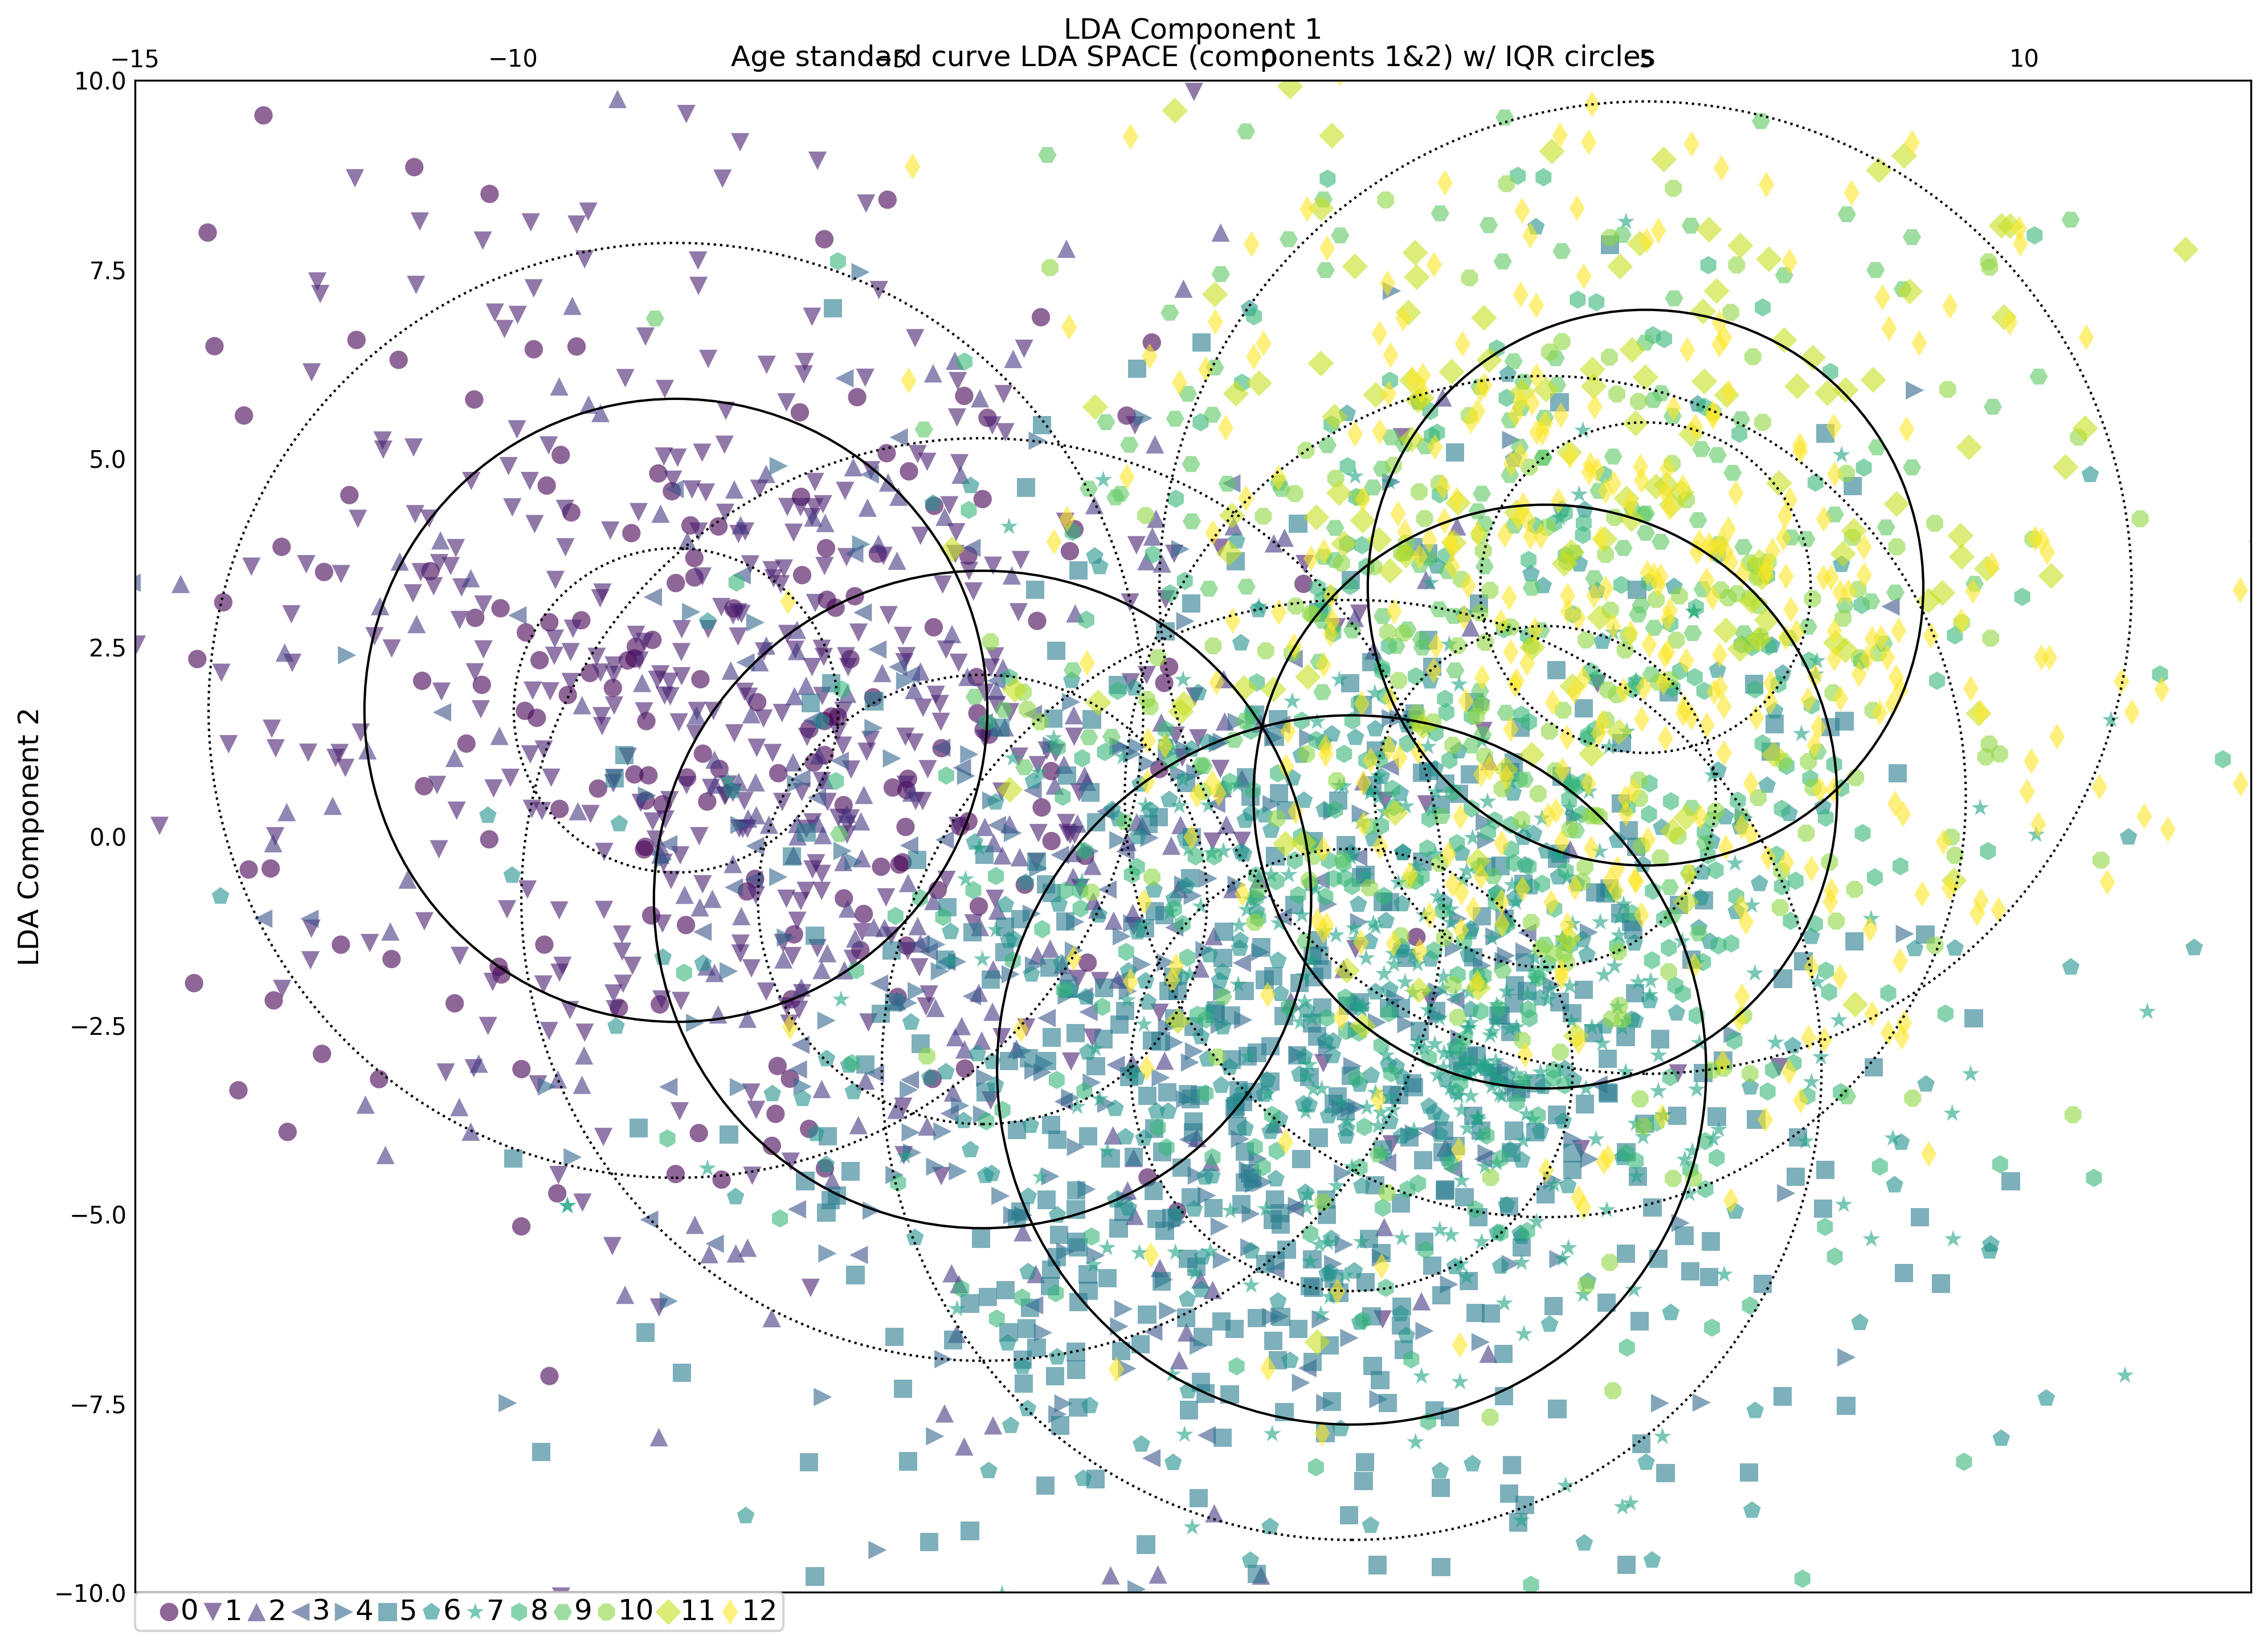

In [39]:
fig = LDA_2D_Projection_Figure( **kwargs )

In [40]:
fig.savefig( "20170816_LDA_figure" )

# Distances from state centroids

Use only the dimensions that correlate with ground truth

In [41]:
state_centroids = state.groupby('state').mean()

In [42]:
state_centroids.drop('age', axis=1, inplace=True)

In [43]:
state_centroids

,LDA0,LDA1
state,,
1.0,-7.842579,1.664552
2.0,-3.785453,-0.837456
3.0,1.098028,-3.091953
4.0,3.660416,0.523947
5.0,4.986879,3.287842


In [45]:
from scipy.spatial.distance import cdist

In [46]:
dists = cdist( df.iloc[:,:ndims].as_matrix(), state_centroids.iloc[:,:ndims].as_matrix() )

In [47]:
dists.shape

(3523, 5)

In [48]:
for i, dim in enumerate( dists.T ):
    df['Dist to State {} Centroid'.format( i+1 )] = dim

# Add ranks

In [49]:
df.head()

,LDA0,LDA1,age,state,Dist to State 1 Centroid,Dist to State 2 Centroid,Dist to State 3 Centroid,Dist to State 4 Centroid,Dist to State 5 Centroid
./00/0.5_01.tif,-2.629817,3.769860,0,NaN,5.621851,4.750037,7.809053,7.078346,7.631932
./00/0.5_02.tif,-3.101211,-14.838146,0,NaN,17.170312,14.017400,12.474239,16.784323,19.848643
./00/0.5_03.tif,-10.410482,2.002269,0,NaN,2.590015,7.207985,12.585583,14.148343,15.450935
./00/0.5_04.tif,-4.770959,0.759586,0,NaN,3.202157,1.876637,7.019926,8.434668,10.080054
./00/0.5_05.tif,-3.062301,2.848125,0,1.0,4.924622,3.755856,7.252094,7.113138,8.061181


In [50]:
for i in range(5):
    sort_by = 'Dist to State {} Centroid'.format( i+1)
    df.sort_values( by=sort_by, inplace=True)
    new_col_name = 'Rank to State {} Centroid'.format( i+1 )
    df[ new_col_name ] = list( range( len( df)))

In [51]:
df.sort_index(inplace=True)

# Interquartile Ranges

In [61]:
for state in range(1,6):
    col_name = "Dist to State {} Centroid".format( state )
    state_dists = list( df.loc[ df.state == state, col_name ] )
    for p in [25, 50, 75]:
        p_dist = np.percentile( state_dists, p )
        new_col_name = "Inside State {} {}th %-ile".format( state, p )
        df[ new_col_name ] = df.loc[ :, col_name ] < p_dist

In [63]:
df.columns

Index(['LDA0', 'LDA1', 'age', 'state', 'Dist to State 1 Centroid',
       'Dist to State 2 Centroid', 'Dist to State 3 Centroid',
       'Dist to State 4 Centroid', 'Dist to State 5 Centroid',
       'Rank to State 1 Centroid', 'Rank to State 2 Centroid',
       'Rank to State 3 Centroid', 'Rank to State 4 Centroid',
       'Rank to State 5 Centroid', 'Inside State 1 25th %-ile',
       'Inside State 1 50th %-ile', 'Inside State 1 75th %-ile',
       'Inside State 2 25th %-ile', 'Inside State 2 50th %-ile',
       'Inside State 2 75th %-ile', 'Inside State 3 25th %-ile',
       'Inside State 3 50th %-ile', 'Inside State 3 75th %-ile',
       'Inside State 4 25th %-ile', 'Inside State 4 50th %-ile',
       'Inside State 4 75th %-ile', 'Inside State 5 25th %-ile',
       'Inside State 5 50th %-ile', 'Inside State 5 75th %-ile'],
      dtype='object')

In [66]:
df.to_excel( '20170816_dme_c_elegans_age_state_percentiles.xls')